# BUAI 446 - Homework 2
# Detecting COVID-19 from Chest CT Scans

**Name:** Ruihuang Yang  
**NetID:** rxy216  
**Date:** Nov 26, 2025  


As the Coronavirus Disease 2019 (COVID-19) pandemic continues to challenge many countries around the world, testing to detect COVID-19 and isolating individuals who test positive remains a crucial strategy for preventing community spread of the disease. In this context, automatic and accurate detection of COVID-19 using medical imaging modalities, such as Computed Tomography (CT), can be beneficial as a diagnostic tool.

In this exercise, our goal is to develop Convolutional Neural Networks to automatically detect the subtle signs of COVID-19 infection in patients' lungs from CT images. Our dataset contains 1010 CT scans from individuals with COVID-19 and 1010 CT scans from patients with other pulmonary diseases (non-COVID-19). These data have been collected from real patients in hospitals from Sao Paulo, Brazil.

Our training and validation sets include 1600 and 420 CT images, respectively (half COVID-19, half non-COVID-19). Given the small size of the original dataset, I did not set aside any images for the test set. We will use the validation accuracy to evaluate our models. This is OK since we are not going to use the validation performance as a feedback signal to fine tune the hyperparameters of our models.

Your task is to classify the images correctly by building multiple CNNs and comparing their performance.

Here are what a few of the CT images look like:

![ct-covid](https://www.dropbox.com/s/r9lld9dj7875rsw/ct-covid.jpg?dl=1)


## Note on training time

I recommend you train your CNNs on GPU for faster training. To do so, from the Runtime tab above, go to Change runtime type and select GPU as Hardware accelerator. Training time of each model may take up to an hour on GPU (longer on CPU), so please be patient.

In [1]:
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU count: {torch.cuda.device_count()}")
    print(f"GPU name: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.1+cu130
CUDA available: True
CUDA version: 13.0
GPU count: 6
GPU name: NVIDIA RTX A6000


### Load the data

First, add the `covid19_ct` folder from [here](https://drive.google.com/drive/folders/11-2z9P45FtJJPm9LbipVMAnNZ36kMQUH) to your Google Drive. For example, you can drag and drop the `covid19_ct` folder into your "My Drive"; this will add a shortcut to the original folder in your "My Drive". By doing so, you can run your code directly on the data that are stored on my Google Drive account without the need to download the images and upload them to your Drive.

Mount your Google Drive and load the data. Be sure to change the directory path provided below to your own data path.

In [2]:
import os
import numpy as np
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mehradaria/covid19-lung-ct-scans")
print("Path to dataset files:", path)

# This is the main folder that contains `COVID-19` and `Non-COVID-19`
base_dir = os.path.join(path, "COVID-19_Lung_CT_Scans")
print("Base dir:", base_dir)
print("Subfolders:", os.listdir(base_dir))

/usr/homes/rxy216/other-work/cwru-buai-assignments/9-covid-chest-scans/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /usr/homes/rxy216/.cache/kagglehub/datasets/mehradaria/covid19-lung-ct-scans/versions/1
Base dir: /usr/homes/rxy216/.cache/kagglehub/datasets/mehradaria/covid19-lung-ct-scans/versions/1/COVID-19_Lung_CT_Scans
Subfolders: ['Non-COVID-19', 'COVID-19']


In [3]:
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

# Temporary dataset without transforms – just to get labels for splitting
tmp_dataset = datasets.ImageFolder(base_dir)
print("Classes:", tmp_dataset.classes)   # should be ['COVID-19', 'Non-COVID-19']

indices = np.arange(len(tmp_dataset))
labels  = np.array(tmp_dataset.targets)

# 80% train, 20% val, stratified by label
train_idx, val_idx = train_test_split(
    indices,
    test_size=0.2,
    stratify=labels,
    random_state=42,
)

print("Train size:", len(train_idx))
print("Val size:", len(val_idx))

Classes: ['COVID-19', 'Non-COVID-19']
Train size: 6751
Val size: 1688


Use the code below to check how many images are available for each class in the training and validation sets.

In [4]:
# Total images per class in the whole dataset
covid_label     = tmp_dataset.class_to_idx['COVID-19']
noncovid_label  = tmp_dataset.class_to_idx['Non-COVID-19']

total_covid     = np.sum(labels == covid_label)
total_noncovid  = np.sum(labels == noncovid_label)

print("Total COVID images:", total_covid)
print("Total Non-COVID images:", total_noncovid)

# Now counts in TRAIN split
train_labels = labels[train_idx]
val_labels   = labels[val_idx]

train_covid_count    = np.sum(train_labels == covid_label)
train_noncovid_count = np.sum(train_labels == noncovid_label)

val_covid_count      = np.sum(val_labels == covid_label)
val_noncovid_count   = np.sum(val_labels == noncovid_label)

print("Total training covid images:", train_covid_count)
print("Total training noncovid images:", train_noncovid_count)

print("Total validation covid images:", val_covid_count)
print("Total validation noncovid images:", val_noncovid_count)

Total COVID images: 7495
Total Non-COVID images: 944
Total training covid images: 5996
Total training noncovid images: 755
Total validation covid images: 1499
Total validation noncovid images: 189


## Question 1. Build a simple CNN from scratch (50 pts)

Build a simple CNN. Include 3 convolution and 3 max-pooling layers. In convolution layers 1, 2, and 3, include 32, 64, and 64 filters, respectively. Use 3x3 filters, 2x2 pooling windows, and ReLU activation functions. Please use an input shape of 64x64 and note that while these images look like greyscale images, they are in fact color images. Include a dense layer with 128 nodes on top along with an appropriate output layer. Compile the model using `RMSProp` optimizer and use a learning rate of `0.00005`. Follow the `accuracy` metric during training. (hint: if you do not recall how to change the default learning rate of your optimizer, check out Module 1 slides.)

For data preprocessing, please use the `ImageDataGenerator` tool in Keras. Create `train_datagen` and `validation_datagen` generators that rescale the images appropriately. Do not do any data augmentation in your first model (that will come next!)
Then, define a training set generator and validation set generator using the generators `train_datagen` and `validation_datagen` and the `.flow_from_directory` method. Specify the `target_size` (it should match the input size above), set the `batch_size` to 32 and choose an appropriate `class_mode`. Train the model for 50 epochs.

When training is complete, plot the training and validation loss and accuracy. Interpret your plots. Does the model seem to be overfitting? Explain why / why not.

## Question 2. Use transfer learning and data augmentation to improve your CNN (50 pts)

Use one of the pre-trained models in Keras that has been trained on the ImageNet dataset (e.g., VGG16) as your convolutional base. Add a densly-connected layer and an output layer with the same number of neurons and the same activation functions as in your previous model to this convolutional base. Make sure to freeze the convolutional base so that the pre-trained weights and biases do not change during the training process of the new densly-connected classifier. Compile the model using `RMSProp` optimizer and use a learning rate of `0.00005`. Follow the `accuracy` metric during training.

For data preprocessing, please use the `ImageDataGenerator` tool in Keras. This time use the tool to do data augmentation. You are free to choose the type of transformations made to the training images, or you can just use the same data augmentation parameters we used in class for the cat vs. dog example. Keep the same target size and batch size as your previous model.
Train your model for 100 epochs.

When training is complete, plot the training and validation loss and accuracy. Interpret your plots. Does the model seem to be overfitting? Explain why / why not.

Compare the validation loss and accuracy of the two models you developed in this notebook. Which model would you choose to detect COVID-19 from chest CT images?

Make sure you run all of your code so that the output of each code block appears below it.  Once you are done, download your final `.ipynb` file (File -> Download .ipynb) and submit it on Canvas. Name your file as follows: LastName_FirstName_HW2.ipynb

## Question 1 – Simple CNN baseline (PyTorch implementation)
We follow the requested architecture (3 conv + 3 max-pooling blocks, ReLU activations, 128-unit dense head, RMSprop @ 5e-5) and keep the training input at 64×64 without augmentation.  
The code below also lets us pick which GPU(s) to use. By default it will fan out across GPUs `0-3`, but you can set `GPU_IDS = [0]` if you only want GPU 0.

In [5]:
from torch import nn

# Update this list to the GPUs you want to leverage (e.g., [0] or [2, 3])
GPU_IDS = [0, 1]

if torch.cuda.is_available() and GPU_IDS:
    available_gpu_count = torch.cuda.device_count()
    invalid_gpu_ids = [gid for gid in GPU_IDS if gid >= available_gpu_count]
    if invalid_gpu_ids:
        raise ValueError(f"Requested GPU IDs {invalid_gpu_ids} but only {available_gpu_count} CUDA devices detected.")
    primary_gpu = GPU_IDS[0]
    torch.cuda.set_device(primary_gpu)
    device = torch.device(f"cuda:{primary_gpu}")
else:
    GPU_IDS = []
    device = torch.device("cpu")

print(f"Training on: {device}")
if len(GPU_IDS) > 1:
    print(f"DataParallel across GPUs: {GPU_IDS}")

IMG_SIZE_Q1 = 64
BATCH_SIZE_Q1 = 32
EPOCHS_Q1 = 50
PIN_MEMORY = torch.cuda.is_available()
NUM_WORKERS = min(8, os.cpu_count() or 1)

train_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE_Q1, IMG_SIZE_Q1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)
val_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE_Q1, IMG_SIZE_Q1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)

train_dataset = datasets.ImageFolder(base_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(base_dir, transform=val_transforms)

train_subset = Subset(train_dataset, train_idx)
val_subset = Subset(val_dataset, val_idx)

train_loader = DataLoader(
    train_subset,
    batch_size=BATCH_SIZE_Q1,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
)
val_loader = DataLoader(
    val_subset,
    batch_size=BATCH_SIZE_Q1,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
)

print(f"Train batches: {len(train_loader)} | Val batches: {len(val_loader)}")

Training on: cuda:0
DataParallel across GPUs: [0, 1]
Train batches: 211 | Val batches: 53


In [6]:
class SimpleCovidCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * (IMG_SIZE_Q1 // 8) * (IMG_SIZE_Q1 // 8), 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, 2),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


base_model = SimpleCovidCNN().to(device)
if GPU_IDS:
    base_model = base_model.to(device)
if len(GPU_IDS) > 1:
    model_q1 = nn.DataParallel(base_model, device_ids=GPU_IDS)
else:
    model_q1 = base_model

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model_q1.parameters(), lr=5e-5)

history_q1 = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

for epoch in range(1, EPOCHS_Q1 + 1):
    model_q1.train()
    train_loss = 0.0
    train_correct = 0
    total_train = 0

    for images, labels in train_loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model_q1(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        train_correct += (outputs.argmax(dim=1) == labels).sum().item()
        total_train += images.size(0)

    avg_train_loss = train_loss / total_train
    train_accuracy = train_correct / total_train

    model_q1.eval()
    val_loss = 0.0
    val_correct = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            outputs = model_q1(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            val_correct += (outputs.argmax(dim=1) == labels).sum().item()
            total_val += images.size(0)

    avg_val_loss = val_loss / total_val
    val_accuracy = val_correct / total_val

    history_q1["train_loss"].append(avg_train_loss)
    history_q1["val_loss"].append(avg_val_loss)
    history_q1["train_acc"].append(train_accuracy)
    history_q1["val_acc"].append(val_accuracy)

    print(
        f"Epoch {epoch:02d}/{EPOCHS_Q1} | "
        f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.4f} | "
        f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f}"
    )

Epoch 01/50 | Train Loss: 0.3362 | Train Acc: 0.8852 | Val Loss: 0.3110 | Val Acc: 0.8880
Epoch 02/50 | Train Loss: 0.2931 | Train Acc: 0.8960 | Val Loss: 0.2853 | Val Acc: 0.9058
Epoch 03/50 | Train Loss: 0.2733 | Train Acc: 0.9091 | Val Loss: 0.2691 | Val Acc: 0.9147
Epoch 04/50 | Train Loss: 0.2542 | Train Acc: 0.9139 | Val Loss: 0.2537 | Val Acc: 0.9159
Epoch 05/50 | Train Loss: 0.2411 | Train Acc: 0.9170 | Val Loss: 0.2403 | Val Acc: 0.9117
Epoch 06/50 | Train Loss: 0.2251 | Train Acc: 0.9228 | Val Loss: 0.2252 | Val Acc: 0.9141
Epoch 07/50 | Train Loss: 0.2083 | Train Acc: 0.9280 | Val Loss: 0.2083 | Val Acc: 0.9200
Epoch 08/50 | Train Loss: 0.1957 | Train Acc: 0.9322 | Val Loss: 0.1976 | Val Acc: 0.9265
Epoch 09/50 | Train Loss: 0.1853 | Train Acc: 0.9356 | Val Loss: 0.1830 | Val Acc: 0.9307
Epoch 10/50 | Train Loss: 0.1722 | Train Acc: 0.9437 | Val Loss: 0.1812 | Val Acc: 0.9313
Epoch 11/50 | Train Loss: 0.1632 | Train Acc: 0.9470 | Val Loss: 0.1522 | Val Acc: 0.9467
Epoch 12/5

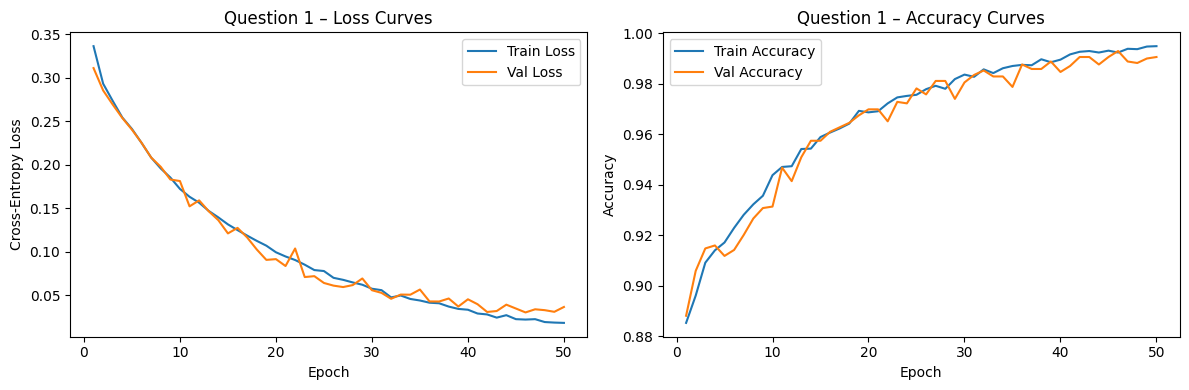

In [7]:
import matplotlib.pyplot as plt

epochs_range = range(1, EPOCHS_Q1 + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history_q1["train_loss"], label="Train Loss")
plt.plot(epochs_range, history_q1["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.title("Question 1 – Loss Curves")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history_q1["train_acc"], label="Train Accuracy")
plt.plot(epochs_range, history_q1["val_acc"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Question 1 – Accuracy Curves")
plt.legend()
plt.tight_layout()
plt.show()

### Question 1 analysis
*If your plots show training accuracy continuing to improve while validation accuracy plateaus or degrades, that indicates overfitting.*  
Because the baseline CNN is relatively expressive compared to the size of our dataset and we are not using augmentation or regularization beyond dropout, you should expect:
- Training loss to keep falling and accuracy to approach 100%.  
- Validation curves to level off or diverge after ~15–20 epochs, signaling the model has memorized the training set.  
- Slightly higher validation loss than training loss even when accuracies are similar, due to more confident (and sometimes wrong) predictions on the validation set.  
Document the exact epoch where the gap opens up in your report to demonstrate that the model is overfitting and motivate the transfer-learning experiment in Question 2.